# **Machine Learning from Data**

## Lab 5: Crossvalidation

2022 - Veronica Vilaplana - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group

-----------------


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, ShuffleSplit

#import sklearn.preprocessing as skl_pre
#import sklearn.linear_model as skl_lm
#import sklearn.discriminant_analysis as skl_da
#import sklearn.neighbors as skl_nb
#import sklearn.model_selection as skl_ms

##Part1: Cross validation in $k$-NN for hyperparameter choice

In this exercise, we will consider the data set `data/biopsy.csv` with data from breast biopsies, for the purpose of diagnosing breast cancer. For each patient, the data set contains nine different attributes (clump thickness, uniformity of cell size, uniformity of cell shape, marginal adhesion, single epithelial cell size, bare nuclei, bland chromatin, normal nucleoli and mitoses) scored on a scale from $1$ to $10$, as well as the physician’s diagnosis (malign or benign).

We will try to determine suitable value of $k$ in $k$-NN for this data. For simplicity, we will only consider the three attributes in columns `V3`, `V4`and `V5` in this problem.

## Biopsy Dataset
This data frame `biopsy` contains the following columns:  
`ID`: sample code number (not unique).  
`V1`: clump thickness.  
`V2`: uniformity of cell size.  
`V3`: uniformity of cell shape.  
`V4`: marginal adhesion.  
`V5`: single epithelial cell size.  
`V6`: bare nuclei (16 values are missing).  
`V7`: bland chromatin.  
`V8`: normal nucleoli.  
`V9`: mitoses.  
`class`: "benign" or "malignant".

### Data loading
Load and familiarize yourself with the data set, using, e.g.`info()`, `describe()`, `pandas.plotting.scatter_matrix()` and `print()`.

In [2]:
# url = 'data/biopsy.csv'
url = 'https://uu-sml.github.io/course-sml-public/data/biopsy.csv'
biopsy = pd.read_csv(url, na_values='?', dtype={'ID': str}).dropna().reset_index()

In [3]:
biopsy.head()

,index,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,class
0,0,1000025,5,1,1,1,2,1.0,3,1,1,benign
1,1,1002945,5,4,4,5,7,10.0,3,2,1,benign
2,2,1015425,3,1,1,1,2,2.0,3,1,1,benign
3,3,1016277,6,8,8,1,3,4.0,3,7,1,benign
4,4,1017023,4,1,1,3,2,1.0,3,1,1,benign


In [4]:
biopsy.describe()

,index,V1,V2,V3,V4,V5,V6,V7,V8,V9
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,351.355783,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,202.563927,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,176.500000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,355.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,526.500000,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,698.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [5]:
biopsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   683 non-null    int64  
 1   ID      683 non-null    object 
 2   V1      683 non-null    int64  
 3   V2      683 non-null    int64  
 4   V3      683 non-null    int64  
 5   V4      683 non-null    int64  
 6   V5      683 non-null    int64  
 7   V6      683 non-null    float64
 8   V7      683 non-null    int64  
 9   V8      683 non-null    int64  
 10  V9      683 non-null    int64  
 11  class   683 non-null    object 
dtypes: float64(1), int64(9), object(2)
memory usage: 64.2+ KB


For simplicity, we will only consider the three attributes in columns `V3`, `V4`and `V5` in this problem.

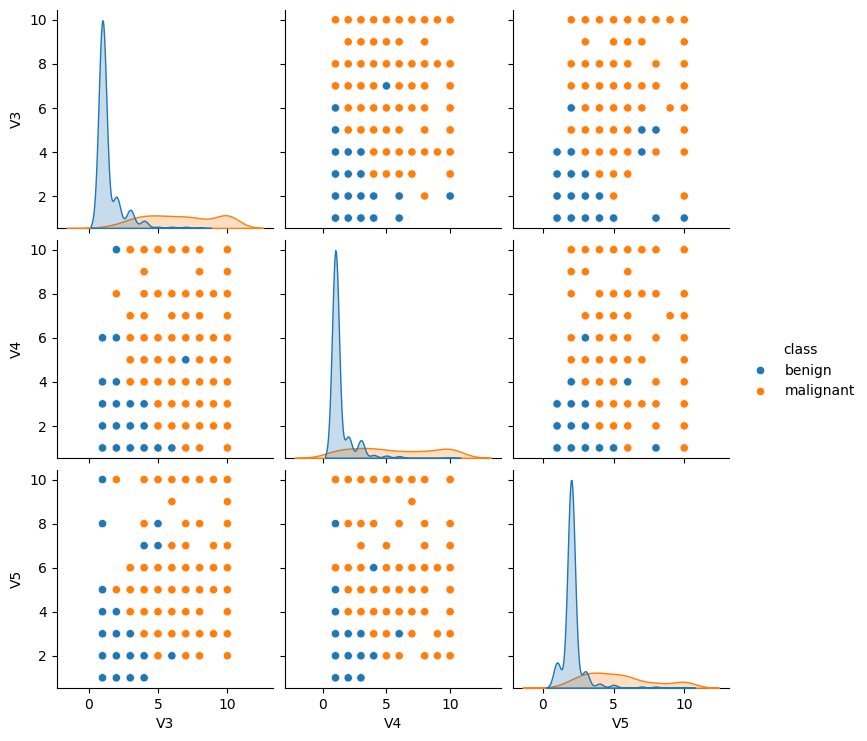

In [6]:
biopsy_small = biopsy[['V3', 'V4', 'V5', 'class']]
# scatter plot
sns.pairplot(biopsy_small,hue = 'class')
plt.draw()

### All data as training data
Consider all data as training data. Investigate how the training error varies with different values of $k$ (hint: use a `for`-loop). Which $k$ gives the best result? Is it a good choice of $k$?

<function matplotlib.pyplot.show(close=None, block=None)>

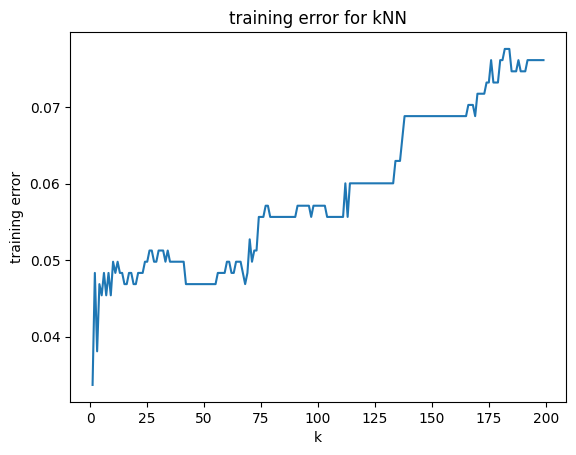

In [7]:
np.random.seed(1)

X = biopsy[['V3', 'V4', 'V5']]
y = biopsy['class']

error = []

K = np.arange(1,200)
for k in K: #try n_neigbours = 1, 2, ..., 199
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X,y)
  pred_x = clf.predict(X)
  error.append(1. - accuracy_score(y, pred_x))
#  error.append(np.mean(pred_x !=y))

plt.plot(K, error)
plt.title('training error for kNN')
plt.xlabel('k')
plt.ylabel('training error')
plt.show

# k=1 has the best performance. That is, however, expected and is not a good measure of which $k$ should be used

### Training and validation sets
Split the data randomly into a training and validation set, and see how well you perform on the validation set. (Previously, we have used the terminology "training" and "test" set. If the other set (not the training set) is used to make design decisions, such as choosing $k$, it is really not a test set, but rather a "validation" set. Hence the
terminology.) Which $k$ gives the best result?

In [8]:
np.random.seed(1)


# we can split data 'manually':
N = len(X)
M = np.ceil(0.7*N).astype(int) # number of training data
print(N)
print(M)
idx = np.random.permutation(N)
X_train, X_val = X.iloc[idx[:M]], X.iloc[idx[M:]]
y_train, y_val = y.iloc[idx[:M]], y.iloc[idx[M:]]


# verify shapes
print('X_train shape=', X_train.shape)
print('y_train shape=', y_train.shape)

print('X_val shape=', X_val.shape)
print('y_val shape=', y_val.shape)


# or we could use sklearn train_test_split function:

# X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, random_state=1)



683
479
X_train shape= (479, 3)
y_train shape= (479,)
X_val shape= (204, 3)
y_val shape= (204,)


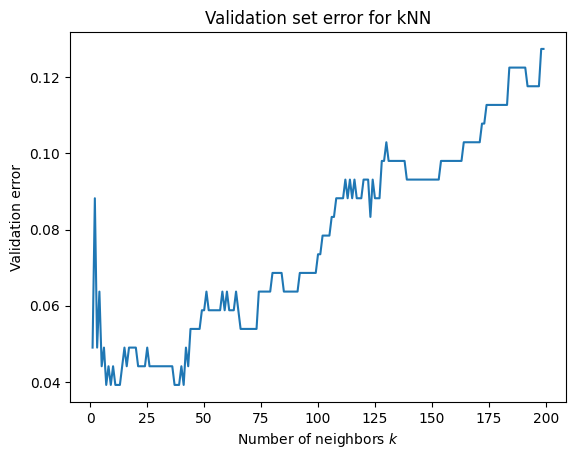

In [9]:
error= []

K = np.arange(1,200)
for k in K:
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X_train,y_train)
  X_val_pred = clf.predict(X_val)
  error.append((1. - accuracy_score(y_val, X_val_pred)))

plt.plot(K, error)
plt.title('Validation set error for kNN')
plt.ylabel('Validation error')
plt.xlabel('Number of neighbors $k$')
plt.show()

# $k$ between 5 and 50 seems good, but the results seems noisy and hard to interpre,


###Random permutations cross-validation a.k.a. Shuffle & Split
Repeat the training 10 times for different train and validation sets and average the results. Which $k$ gives the best result?

Compare the curve with the ones obtained previously


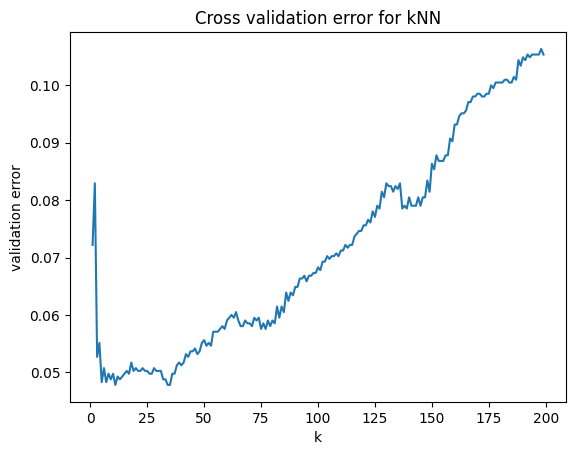

In [10]:
n_runs = 10
K = np.arange(1,200)

error = np.zeros((n_runs, len(K)))

for i in range(n_runs):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

  for j, k in enumerate(K):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    X_val_pred = clf.predict(X_val)
    error[i,j] = 1. - accuracy_score(y_val, X_val_pred)

average_error = np.mean(error, axis=0)

plt.plot(K, average_error)
plt.title('Cross validation error for kNN')
plt.xlabel('k')
plt.ylabel('validation error')
plt.show()

# the results show that k between 5 and 35 perform the best


We can also use the ´ShuffleSplit´ iterator.

The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets. It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.



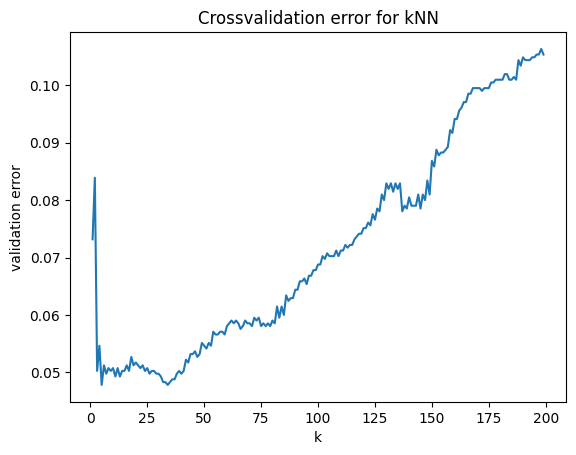

In [11]:
n_runs = 10

K = np.arange(1,200)
error = np.zeros(len(K))

ss = ShuffleSplit(n_splits=n_runs, test_size=0.3, random_state=1)
for train_index, val_index in ss.split(X):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  for j, k in enumerate(K):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    X_val_pred = clf.predict(X_val)
    error[j] += 1. - accuracy_score(y_val, X_val_pred)

error /= n_runs

plt.plot(K, error)
plt.title('Crossvalidation error for kNN')
plt.xlabel('k')
plt.ylabel('validation error')
plt.show()


In [12]:
ss = ShuffleSplit(n_splits=n_runs, test_size=0.3, random_state=1)
print(ss)

ShuffleSplit(n_splits=10, random_state=1, test_size=0.3, train_size=None)


### Kfold cross-validation
Perform 10-fold cross-validation. First, randomly pemute the data set, divide the data set into 10 equally sized parts and loop through them by taking one part as validation set and the rest as training set each time. Which $k$ gives the best result?

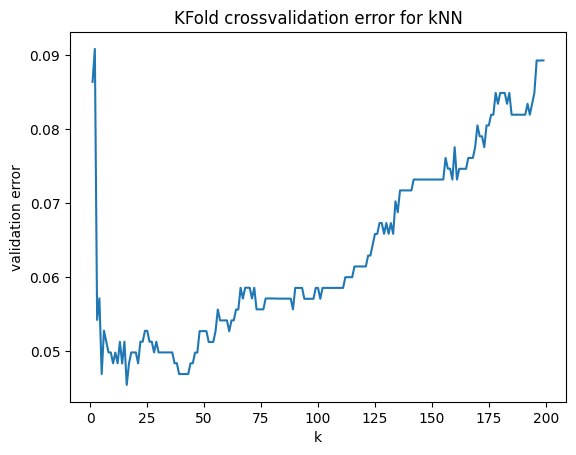

In [13]:
n_fold = 10

K = np.arange(1,200)

error = np.zeros(len(K))

cv = KFold(n_splits = n_fold, random_state = 1, shuffle = True)

for train_index, val_index in cv.split(X):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  for j, k in enumerate(K):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    X_val_pred = clf.predict(X_val)
    error[j] += 1. - accuracy_score(y_val, X_val_pred)

error /= n_fold

plt.plot(K, error)
plt.title('KFold crossvalidation error for kNN')
plt.xlabel('k')
plt.ylabel('validation error')
plt.show()


### Using GridSearchCV

Now, we will do the same but using GridSearchCV. We will use ShuffleSplit and KFold strategies.

We use ShuffleSplit first, with 5 repetitions

In [14]:
K = list(range(1,200))

clf = KNeighborsClassifier()

# we define the cross-validation splitting strategy.
cv_type=ShuffleSplit(n_splits=5, train_size=0.7,random_state=1)

grid_search_cv = GridSearchCV(estimator = clf,
                              param_grid={"n_neighbors": K},
                              cv=cv_type, return_train_score=True)


In [ ]:
grid_search_cv.fit(X, y)

In [ ]:
plt.plot(grid_search_cv.cv_results_["param_n_neighbors"].data, 1. - grid_search_cv.cv_results_["mean_train_score"], label="train")
plt.plot(grid_search_cv.cv_results_["param_n_neighbors"].data, 1. - grid_search_cv.cv_results_["mean_test_score"], label="val")
plt.legend()
plt.title("Error");

Now we use KFold, with $k=5$.

What's the difference between using ShuffleSplit with n-splits=5 and 5-Fold cross validation?

In [ ]:
K = list(range(1,200))

clf = KNeighborsClassifier()

# we define the cross-validation splitting strategy
cv_type = KFold(5)

grid_search_cv = GridSearchCV(estimator = clf,
                              param_grid={"n_neighbors": K},
                              cv=cv_type, return_train_score=True)


In [ ]:
grid_search_cv.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             return_train_score=True)

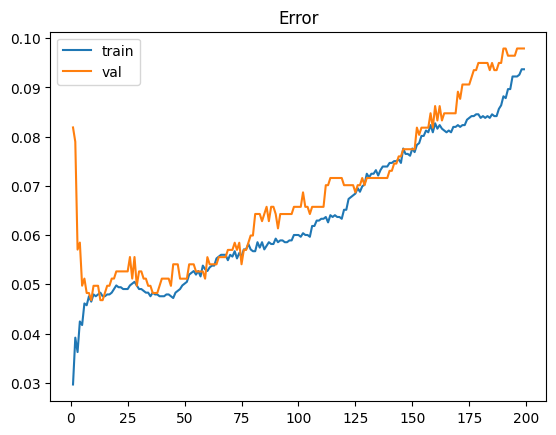

In [ ]:
plt.plot(grid_search_cv.cv_results_["param_n_neighbors"].data, 1. - grid_search_cv.cv_results_["mean_train_score"], label="train")
plt.plot(grid_search_cv.cv_results_["param_n_neighbors"].data, 1. - grid_search_cv.cv_results_["mean_test_score"], label="val")
plt.legend()
plt.title("Error");

##Part2: Cross validation for model choice

In this problem we will consider the data sets `pima_tr.csv` and `pima_te.csv`. Your task is to do as good prediction as possible for the test set `pima_te`, but you are only allowed to look at the true output in `pima_te` once. Hence, you will have to use `pima_tr` for both deciding which model to use and training the model.

The data set describes the prevalence of diabetes in women at least 21 years old of Pima Indian heritage, living near Phoenix, Arizona, USA. The data set describes, for each individual, whether she has diabetes or not, her age, the diabetes pedigree function (a summary of the diabetes history in her family), BMI, skin thickness, blood pressure, plasma glucose concentration and number of pregnancies.

The data frame contains the following columns:  
`npreg` number of pregnancies.  
`glu` plasma glucose concentration in an oral glucose tolerance test.  
`bp` diastolic blood pressure (mm Hg).  
`skin` triceps skin fold thickness (mm).  
`bmi` body mass index (weight in kg/(height in m)\^2).  
`ped` diabetes pedigree function.  
`age` age in years.  
`type` Yes or No, for diabetic according to WHO criteria.

###1. Dataset
Load the dataset and familiarize with it

In [ ]:
# Load the datasets
from google.colab import drive
drive.mount('/content/drive')

pima_tr = pd.read_csv('drive/MyDrive/MLEARN/Lab/Lab5/pima_tr.csv')
pima_te = pd.read_csv('drive/MyDrive/MLEARN/Lab/Lab5/pima_te.csv')

ValueError: mount failed

In [ ]:
pima_tr.describe()

### 2. Fitting models
See how well you can fit the `pima_tr` LDA, QDA and k-NN (k = 2). The output is whether an individual has diabetes or not, and the input the remaining variables.

###2.1. Use the whole training set to train and evaluate the models.

What error rate does each method have?

Is it a good indicator of which method is preferable?

In [ ]:
X = pima_tr.drop(columns=['type'])
y = pima_tr['type']

In [ ]:
# LDA
model1 = LinearDiscriminantAnalysis()
model1.fit(X,y)
X_pred = model1.predict(X)
err = 1. - accuracy_score(y, X_pred)
print('Error rate for LDA: ' + str(err))

# QDA
model2 = QuadraticDiscriminantAnalysis()
model2.fit(X,y)
X_pred = model2.predict(X)
err = 1. - accuracy_score(y, X_pred)
print('Error rate for QDA: ' + str(err))

# kNN
model3 = KNeighborsClassifier(n_neighbors=2)
model3.fit(X,y)
X_pred = model3.predict(X)
err = 1. - accuracy_score(y, X_pred)
print('Error rate for kNN: ' + str(err))

### 2.2. 10-fold cross validation

Now perform 10-fold cross-validation by first randomly permute `pima_tr` and divide it in 10 parts. Then, in a loop with one of the 10 parts held out as validation data, fit LDA, QDA and k-NN (k = 2) to the training data and evaluate the performance on the validation data. Plot your results in a box plot with the error rates. Feel free to play around with the choice of inputs and other settings to improve the performance. Which method does this suggest us to use?

In [ ]:
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=1)

model1 = LinearDiscriminantAnalysis()
model2 = QuadraticDiscriminantAnalysis()
model3 = KNeighborsClassifier(n_neighbors=2)

err1_score = []
err2_score = []
err3_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]

    model1.fit(X_train,y_train)
    X_pred_1 = model1.predict(X_test)

    model2.fit(X_train,y_train)
    X_pred_2 = model2.predict(X_test)

    model3.fit(X_train,y_train)
    X_pred_3 = model3.predict(X_test)


    err1 = 1. - accuracy_score(X_pred_1 , y_test)
    err1_score.append(err1)

    err2 = 1. - accuracy_score(X_pred_2 , y_test)
    err2_score.append(err2)

    err3 = 1.- accuracy_score(X_pred_3 , y_test)
    err3_score.append(err3)

avg_err1_score = sum(err1_score)/k
avg_err2_score = sum(err2_score)/k
avg_err3_score = sum(err3_score)/k

print('LDA errpr of each fold - {}'.format(err1_score))
print('LDA Avg error : {}'.format(avg_err1_score))

print('QDA error of each fold - {}'.format(err2_score))
print('QDA Avg error : {}'.format(avg_err2_score))

print('kNN error of each fold - {}'.format(err3_score))
print('kNN Avg error : {}'.format(avg_err3_score))



In [ ]:
all = [err1_score, err2_score, err3_score]
plt.boxplot(all)
plt.title('Cross validation error for different models')
plt.xticks(np.arange(3)+1, ('LDA', 'QDA', 'kNN'))
plt.ylabel('validation error')
plt.show()

### 2.3. Evaluation

Now, decide which method to choose and train it on the entire data set `pima_tr` and predict `pima_te`. How well do you perform?

In [ ]:
# I choose LDA

X_test = pima_te.drop(columns=['type'])
y_test = pima_te['type']

model = LinearDiscriminantAnalysis()
model.fit(X,y)
X_pred = model.predict(X)
X_test_pred = model.predict(X_test)

err_train = 1. - accuracy_score(X_pred , y)
err_test = 1. - accuracy_score(X_test_pred , y_test)

print('LDA training error - {}'.format(err_train))
print('LDA test error - {}'.format(err_test))


Now, since we are in a simulated environment, we can cheat and break the rule that we were only allowed to look at the true output in `pima_te` once. That is, explore how well the other methods do when you train them on `pima_tr` and predict `pima_te`. Did you make the "right" choice in the previous question?

In [ ]:
X_test = pima_te.drop(columns=['type'])
y_test = pima_te['type']

# LDA
model1 = LinearDiscriminantAnalysis()
model1.fit(X,y)
X_test_pred = model1.predict(X_test)
err = 1. - accuracy_score(y_test, X_test_pred)
print('Error rate for LDA: ' + str(err))

# QDA
model2 = QuadraticDiscriminantAnalysis()
model2.fit(X,y)
X_test_pred = model2.predict(X_test)
err = 1. - accuracy_score(y_test, X_test_pred)
print('Error rate for QDA: ' + str(err))

# kNN
model3 = KNeighborsClassifier(n_neighbors=2)
model3.fit(X,y)
X_test_pred = model3.predict(X_test)
err = 1. - accuracy_score(y_test, X_test_pred)
print('Error rate for kNN: ' + str(err))